# SPY Collar Test
This Jupyter Notebook is adapted from a Python script designed for simple show case of financial data analysis, including data loading, cleaning, strategy implementation, and portfolio simulation.

## Step 1: Import Necessary Libraries and Modules
In this section, we import the necessary Python libraries and custom modules required for our analysis.

In [1]:
import pandas as pd
import tqdm
from asset import asset
from data import data_handler
from strategy import strategy
from portfolio import portfolio

### Configuration
Adjusting configuration settings for libraries to ensure smooth operation of the notebook.

In [2]:
pd.options.mode.chained_assignment = None

## Step 2: Data Preparation
Here, we load the financial data from Excel files using custom data handling utilities.

In [3]:
# read data from excel
price_data = data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='Price'
                                                      ).iloc[:, 0:2]
dividend_data = data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='Dividend'
                                                         ).iloc[:, 0:5].rename(columns={'Amount': 'Dividends'})
dividend_yld_data = data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='Price'
                                                             ).loc[:, ['Date', '12M Div Yield']
                    ].rename(columns={'12M Div Yield': 'Dividend_Yield'})
curve_rate_data = data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='Interest Rate')

# read multiple sheets 30IV, 60IV, 90IV, 180IV, 360IV from Excel into one pandas dataframe
iv_data = pd.concat([data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='30IV'
                                                              ).set_index('Date'),
                     data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='60IV'
                                                              ).set_index('Date'),
                     data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='90IV'
                                                              ).set_index('Date'),
                     data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='180IV'
                                                              ).set_index('Date'),
                     data_handler.DataHandler.load_excel_data('./data/Coding_Proj_Data.xls', sheet_name='360IV'
                                                              ).set_index('Date')], axis=1)
iv_data = iv_data.iloc[1:, :].reset_index()
iv_data.columns.name = 'Master_Ticker'

# set the first row of curve_rate_data the tenor and make it column name
curve_rate_data.columns = curve_rate_data.iloc[0]
curve_rate_data = curve_rate_data.iloc[1:, :].reset_index(drop=True)
# curve data issue on Tenor(D) 7.0 and 60.0 after 2022-01-01, fill with NA, interpolation will be done later
curve_rate_data.loc['2022-01-01':, [7.0, 60.0]] = None
# curve data issue on Tenor(D) 1 and 360 after 2023-07-01, send warning
print('Suspect Curve data issue on Tenor(D) 1 and 360 after 2023-07-01!')

# clean data
price_data = data_handler.DataHandler.clean_time_series(price_data, 'Date')
dividend_data = data_handler.DataHandler.clean_time_series(dividend_data, 'ExDate')
curve_rate_data = data_handler.DataHandler.clean_time_series(curve_rate_data, 'Date', how_drop_na='all')
cash_rate_data = curve_rate_data.loc[:, 1].to_frame('cash_rate')
iv_data = data_handler.DataHandler.clean_time_series(iv_data, 'Date')
dividend_yld_data = data_handler.DataHandler.clean_time_series(dividend_yld_data, 'Date')

# check data
data_handler.DataHandler.print_missing_data_pct_by_col(price_data)
data_handler.DataHandler.print_missing_data_pct_by_col(dividend_data)

# further modify implied volatility data
iv_data = iv_data.unstack().reset_index().rename(columns={0: 'Value'}).set_index('Date')
iv_data['Maturity'] = iv_data['Master_Ticker'].str.extract(r'(\d+DAY|\d+MTH)'
                                                           )[0].str.replace('DAY', 'D').str.replace('MTH', 'M')
iv_data['Maturity'] = iv_data['Maturity'].apply(lambda x: data_handler.DataHandler.date_convert(x, target_freq='D'))
iv_data['Moneyness'] = iv_data['Master_Ticker'].str.extract(r'(\d+\.?\d*)%MNY')[0].astype(float)

Suspect Curve data issue on Tenor(D) 1 and 360 after 2023-07-01!
Price    0.0
dtype: float64
Date          0.0
RecordDate    0.0
PayDate       0.0
Dividends     0.0
dtype: float64


## Step 3: Create Asset for Strategy

In [5]:

# create ETF Asset
# assume 3 cents per share transaction cost
spy_etf = asset.ETF(name='SPY', master_ticker='SPY', price=price_data, dividend=dividend_data, transaction_cost=0.03)
spy_etf.total_return_calc()
spy_etf.forward_return_generate()

# create Cash Asset
cash = asset.Cash(name='Cash', master_ticker='CASH', cash_rate=cash_rate_data, currency='USD')
# convention could be ACT/365 or ACT/252, I choose 252 here
# because I remove non-business date in previous steps to make data consistent, there are ~252 business days in a year
# is an appropriate assumption
cash.total_return_calc(convention='ACT/252')

# create Curve Asset
curve_rate_data.columns.name = 'Tenor'
curve = asset.Curve(name='Curves', master_ticker='CURVE', curve_rate=curve_rate_data)
curve.interpolation()

# create basket of options used in the portfolio
portfolio_start_date = max(spy_etf.total_return_index.index.min(), cash.cash_rate.index.min(),
                           curve.curve_rate.index.min(), iv_data.index.min()
                           , pd.to_datetime('2005-06-30')).strftime('%Y-%m-%d')
portfolio_end_date = min(spy_etf.total_return_index.index.max(), cash.cash_rate.index.max(),
                         curve.curve_rate.index.max(), iv_data.index.max()
                         , pd.to_datetime('2023-12-31')).strftime('%Y-%m-%d')
potential_rebalance_dates = portfolio.MultiAssetPortfolio.rebalance_time_series(spy_etf.price.index,
                                                                                portfolio_start_date,
                                                                                portfolio_end_date, rebalance_freq='M')


Create for Option

In [6]:
option_basket = []
# master_ticker = "OPTION" +OPTION_TYPE+underlying+moneyness+strike_price+maturity_date
original_option_config = {'name': '',
                          'master_ticker': '',
                          'exercise_type': 'European',
                          'transaction_cost': 4,
                          'underlying_price': spy_etf.price,
                          'risk_free_rate': curve.curve_rate,
                          'underlying_dividend': dividend_yld_data,
                          'contract_unit': 100,
                          'implied_vol': iv_data[['Value', 'Maturity', 'Moneyness']],
                          'intend_purchase_date': '',
                          }
# every 3 months loop
# all these for loop could be parallelized to improve performance
if_read_cache = False # # if read the option_basket from local cache. Not applicable for the first time
if if_read_cache:
    option_basket = data_handler.DataHandler.load_pickle_data('.\data\option_basket.pkl')
else:
    # wrap the for loop with tqdm to show the progress bar with title creating option basket
    for intend_put_purchase_date in tqdm.tqdm(potential_rebalance_dates[::3]['Rebalance Date'],
                                              desc='Creating Put Option Basket'):
        # for intend_put_purchase_date in potential_rebalance_dates[::3]['Rebalance Date']:
        # SPY 95% strike OTM put. put option with 95% strike price and 3, 6, 9, 12 month maturity
        for maturity in [3, 6, 9, 12]:
            option_config = original_option_config.copy()
            maturity_date = intend_put_purchase_date + pd.offsets.BMonthEnd(maturity)
            strike_price = int(spy_etf.price.loc[intend_put_purchase_date, 'Price'] * 0.95)
            option_config['name'] = 'OPTION_PUT_SPY_95_' + str(strike_price) + '_' + maturity_date.strftime('%Y%m%d')
            option_config['master_ticker'] = ('OPTION_PUT_SPY_95_' + str(strike_price) + '_' +
                                              maturity_date.strftime('%Y%m%d'))
            option_config['intend_purchase_date'] = intend_put_purchase_date.strftime('%Y-%m-%d')
            option_temp = asset.Option(**option_config)
            # could change to <BinomialTree> for American option
            option_temp.get_pricing(model='BSM', div_model='12m_continuous')
            option_temp.total_return_calc()
            option_basket.append(option_temp)
    for intend_call_write_date in tqdm.tqdm(potential_rebalance_dates['Rebalance Date'],
                                            desc='Creating Call Option Basket'):
        # for intend_call_write_date in potential_rebalance_dates['Rebalance Date']:
        # Sell SPY 105% strike OTM call. The maturity of the contracts is 1 month.
        option_config = original_option_config.copy()
        maturity_date = intend_call_write_date + pd.offsets.BMonthEnd(1)
        strike_price = int(spy_etf.price.loc[intend_call_write_date, 'Price'] * 1.05)
        option_config['name'] = 'OPTION_CALL_SPY_105_' + str(strike_price) + '_' + maturity_date.strftime('%Y%m%d')
        option_config['master_ticker'] = ('OPTION_CALL_SPY_105_' + str(strike_price) + '_' +
                                          maturity_date.strftime('%Y%m%d'))
        option_config['intend_purchase_date'] = intend_call_write_date.strftime('%Y-%m-%d')
        option_temp = asset.Option(**option_config)
        # could change to <BinomialTree> for American option
        option_temp.get_pricing(model='BSM', div_model='12m_continuous')
        option_temp.total_return_calc()
        option_basket.append(option_temp)
    # save option_basket to local cache
    data_handler.DataHandler.save_pickle_data(option_basket, '.\data\option_basket.pkl')


Creating Call Option Basket: 100%|███████████| 223/223 [00:19<00:00, 11.67it/s]


## Step 4: Strategy Implementation

In [7]:
# create collar strategy
spy_collar_strategy = strategy.Collar(name='SPY Collar Strategy', data=spy_etf.price, start_date=portfolio_start_date,
                                      end_date=portfolio_end_date, underlying_ticker=spy_etf.master_ticker,
                                      rebalance_freq='M', put_maturity_basket=[3, 6, 9, 12], call_maturity_basket=[1],
                                      put_moneyness=95, call_moneyness=105)
spy_collar_strategy.signal_generation()

Collar Strategy Signal Generation: 100%|█| 4827/4827 [00:03<00:00, 1237.21it/s]


,master_ticker,signal
Date,,
2005-06-30,SPY,1.0
2005-07-01,SPY,1.0
2005-07-04,SPY,1.0
2005-07-05,SPY,1.0
2005-07-06,SPY,1.0
...,...,...
2023-12-29,OPTION_PUT_SPY_95_451_20240329,1.0
2023-12-29,OPTION_PUT_SPY_95_451_20240628,1.0
2023-12-29,OPTION_PUT_SPY_95_451_20240930,1.0


## Step 5: Portfolio Simulation

Backtesting Strategy: 100%|████████████████| 4827/4827 [01:32<00:00, 52.23it/s]


Trade output generated for portfolio:  SPY Collar
Performance analysis generated for portfolio:  SPY Collar
Backtesting finished for portfolio:  SPY Collar


D:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


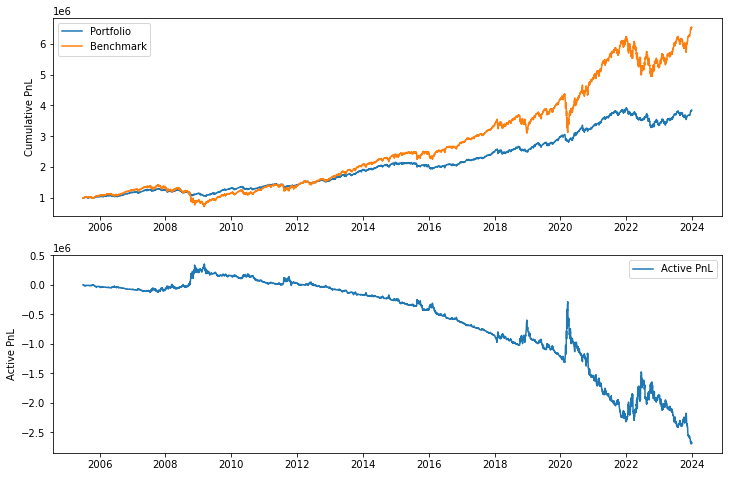

In [8]:
# create Portfolio
spy_collar_portfolio = portfolio.MultiAssetPortfolio(name='SPY Collar',
                                                     asset_list=[spy_etf, cash] + option_basket,
                                                     start_date=portfolio_start_date, end_date=portfolio_end_date,
                                                     initial_capital=1000000, rebalance_freq='M',
                                                     benchmark=spy_etf.total_return_index.to_frame('SPY'),
                                                     signal_data=spy_collar_strategy.signal_history)
spy_collar_portfolio.backtesting(is_generate_output=True, portfolio_construct_method='Collar')

In [9]:
spy_collar_portfolio.portfolio_account.head(5)

,NAV,Income,Available_Cash,Unavailable_Cash
Date,,,,
2005-06-30,998724.0,0,10415.216397,0.0
2005-07-01,1000499.91338,1.37578,10416.592177,0.0
2005-07-04,1000349.782304,2.751741,10417.968138,0.0
2005-07-05,1004919.865761,4.116516,10419.332913,0.0
2005-07-06,999935.809098,5.480952,10420.697349,0.0


In [11]:
spy_collar_portfolio.trade_records.head(10)

,Trade Date,Master_Ticker,Amount,Price,Transaction_Cost,Side,Trade_Rational
0,2005-06-30,OPTION_CALL_SPY_105_87_20050729,-116.0,0.084267,464.0,Sell,Rebalance
0,2005-06-30,OPTION_PUT_SPY_95_79_20050930,29.0,0.740079,116.0,Buy,Rebalance
0,2005-06-30,OPTION_PUT_SPY_95_79_20051230,29.0,1.529006,116.0,Buy,Rebalance
0,2005-06-30,OPTION_PUT_SPY_95_79_20060331,29.0,2.16524,116.0,Buy,Rebalance
0,2005-06-30,OPTION_PUT_SPY_95_79_20060630,29.0,2.683674,116.0,Buy,Rebalance
0,2005-06-30,SPY,11600.0,83.5038,348.0,Buy,Rebalance
0,2005-07-29,OPTION_CALL_SPY_105_87_20050729,116.0,0.0,464.0,Buy,Roll
0,2005-07-29,OPTION_CALL_SPY_105_91_20050831,-116.0,0.054937,464.0,Sell,Roll
0,2005-08-31,OPTION_CALL_SPY_105_91_20050831,116.0,0.0,464.0,Buy,Roll
0,2005-08-31,OPTION_CALL_SPY_105_90_20050930,-116.0,0.068112,464.0,Sell,Roll
